In [1]:
# uncomment below if you see a gribscan module not found error
#%pip install gribscan

In [2]:
#1)uncomment below to install the hackathon python environment (only needed once). 
#2)After installing, refresh the jupyter browser and select as kernel the newly installed one (click on top-right, look for python-HH-hackathon)
#3)You can then comment this line again
#!module use /work/k20200/k202134/hsm-tools/outtake/module; module load python3/hamburg-hackathon; python -m ipykernel install --name python-HH-hackathon --user

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cf
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import gribscan
import intake
import eccodes
import healpy as hp
import os

In [4]:
# check that the right eccodes version is available (>=2.32.5)
#eccodes.codes_get_version_info(), eccodes.codes_get_library_path()

In [5]:
def attach_coords(ds):
    model_lon = ds.lon.values
    model_lat = ds.lat.values
    return ds.assign_coords(
        lat = (("value",), model_lat, {"units": "degree_north"}),
        lon = (("value",), model_lon, {"units": "degree_east"}),
    )

In [6]:
#####calculate the temporal mean
def sel_box(data,latitude,longitude):
    dsel = data.where(((data.lat>=latitude[0]) & (data.lat<=latitude[1])) & ((data.lon>=longitude[0]) & (data.lon<=longitude[1])),drop=True)

    return dsel

In [7]:
def deaccumulate_ifs_hourly(var):
    time_day=var.groupby('time.day').groups  
    time_hour=var.groupby('time.hour').groups
    idx_day1=time_day[1] 
    idx_hour1=time_hour[1] 
    idx_day1_hour1 = list(sorted(set(idx_day1).intersection(idx_hour1)))
    var_deacc=var.diff(dim='time', label='upper')
    # add first time step to have same number of time steps for var_deacc as for var
    var_deacc = xr.concat([var.isel(time=slice(0,1)),var_deacc], dim='time')
    # replace steps that are wrong because of resetted accumulation
    var_deacc[idx_day1_hour1,:]=var[idx_day1_hour1,:]
    # drop first step because it is zero
    var_deacc = var_deacc[1::,:]
    return var_deacc

### Extra-quick version: Get interpolated & averaged IFS-FESOM (TCo1279-NG5) production data and create quick plots

In [8]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")

In [9]:
# which IFS experiments are available?
print(list(cat.IFS))

['IFS_9-FESOM_5-production', 'IFS_4.4-FESOM_5-cycle3', 'IFS_9-FESOM_5-cycle3', 'IFS_9-NEMO_25-cycle3', 'IFS_28-NEMO_25-cycle3', 'IFS_28-FESOM_25-cycle3', 'IFS_4.4-FESOM_5-cycle3-nofastdata', 'IFS_4.4-FESOM_5-cycle3-fastdata', 'IFS_grids']


In [10]:
### select simulation / prefix
ifs_run='IFS_9-FESOM_5-production'
print(list(cat.IFS[ifs_run])) 

['2D_hourly_healpix512', '2D_hourly_healpix512_2020s', '2D_hourly_healpix512_2030s', '2D_hourly_healpix512_2040s', '2D_daily_healpix512_ocean', '3D_hourly_healpix512', '3D_hourly_healpix512_2020', '3D_hourly_healpix512_2025', '3D_hourly_healpix512_2030', '3D_hourly_healpix512_2035', '3D_hourly_healpix512_2040', '3D_hourly_healpix512_2045', '3D_hourly_healpix512_snow', '3D_daily_healpix512_ocean', '2D_monthly_healpix512', '2D_monthly_healpix512_sst_ci_winds', '3D_monthly_healpix512', '3D_monthly_healpix512_snow', '2D_hourly_healpix128', '3D_hourly_healpix128_2020', '3D_hourly_healpix128_2025', '3D_hourly_healpix128_2030', '3D_hourly_healpix128_2035', '3D_hourly_healpix128_2040', '3D_hourly_healpix128_2045', '2D_daily_healpix128_ocean', '3D_daily_healpix128_ocean', '3D_hourly_0.25deg_2020s', '3D_hourly_0.25deg_2030s', '3D_hourly_0.25deg_2040s', '3D_hourly_native_2020s', '3D_hourly_native_2030s', '2D_monthly_0.25deg', '2D_monthly_0.25deg_snow', '2D_monthly_0.25deg_sst_ci_winds', '3D_month

In [13]:
# select the data resolution in space and time you need
ds = cat.IFS['IFS_9-FESOM_5-production']['2D_hourly_healpix512_2020s'].to_dask().pipe(attach_coords) # load H512, hourly

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'rasterio' loading failed:
No module named 'affine'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


In [16]:
ds #litota1

<xarray.Dataset>
Dimensions:  (time: 87226, value: 3145728)
Coordinates:
    lat      (value) float64 0.0746 0.1492 0.1492 ... -0.1492 -0.1492 -0.0746
    lon      (value) float64 45.0 45.09 44.91 45.0 ... 315.0 315.1 314.9 315.0
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2030-01-01
Dimensions without coordinates: value
Data variables: (12/57)
    10u      (time, value) float64 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    10v      (time, value) float64 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    2d       (time, value) float64 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    2t       (time, value) float64 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    blh      (time, value) float64 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    chnk     (time, value) float64 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    ...       ...
    tp       (time, value) float64 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    tprate   (time, value) float64 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    tsr      (time, value) float64 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    tsrc     (time, value) float64 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    ttr      (time, value) float64 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    ttrc     (time, value) float64 dask.array<chunksize=(1, 3145728), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          1003
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

In [14]:
#### select period
### summer
ifs_jja = ds.tp.sel(time=ds.tp.time.dt.month.isin([6, 7, 8]))
ifs_jja

<xarray.DataArray 'tp' (time: 22080, value: 3145728)>
dask.array<getitem, shape=(22080, 3145728), dtype=float64, chunksize=(1, 3145728), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 0.0746 0.1492 0.1492 ... -0.1492 -0.1492 -0.0746
    lon      (value) float64 45.0 45.09 44.91 45.0 ... 315.0 315.1 314.9 315.0
  * time     (time) datetime64[ns] 2020-06-01 ... 2029-08-31T23:00:00
Dimensions without coordinates: value
Attributes: (12/14)
    paramId:                    228
    dataType:                   fc
    numberOfPoints:             3145728
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   accum
    ...                         ...
    units:                      m
    name:                       Total precipitation
    cfVarName:                  tp
    missingValue:               9999
    NV:                         0
    gridDefinitionDescription:  150

In [15]:
###Select a region: domain - south of alps
region='south' # south, north, sw_greenland, 'sonnblick'
#lons = 8., 9.5
#lats = 45.5, 46.5
### North of alps
#lons = 7., 8.5
#lats = 47., 48.

In [16]:
#domains
domains = {'usa_msc': {'lons':[262,272], 'lats':[31,41]},
           'usa_lojko': {'lons':[271,287], 'lats':[44,54]},
        'south': {'lons':[8,9.5], 'lats':[45.5,46.5]},
            'north': {'lons':[7., 8.5], 'lats':[47., 48.]},
            #'sw_greenland': {'lons':[-51.,-48.0], 'lats':[66., 68.]},
            'sw_greenland': {'lons':[309,312], 'lats':[66., 68.]},
            'sonnblick': {'lons':[12, 13.5], 'lats':[46.5, 47.5]}
          }
print(domains[region]['lats'],domains[region]['lons'])

[45.5, 46.5] [8, 9.5]


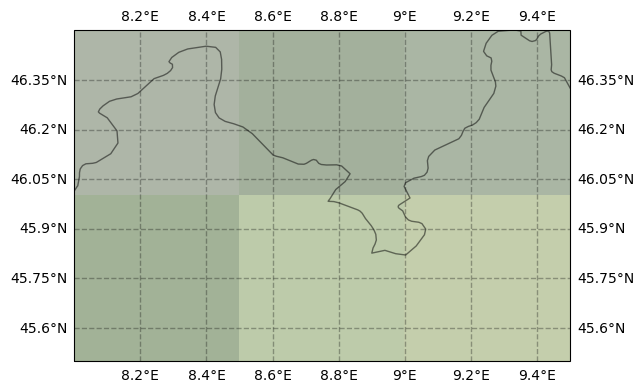

In [17]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
ax.set_extent([domains[region]['lons'][0], domains[region]['lons'][1], domains[region]['lats'][0], domains[region]['lats'][1]])
gl=ax.gridlines(linewidth=1, color='black', alpha=0.3, linestyle='--', draw_labels=True)

In [18]:
###Select a region
lons = domains[region]['lons']
lats =domains[region]['lats']
domain=sel_box(ifs_jja,lats,lons)
domain


<xarray.DataArray 'tp' (time: 22080, value: 78)>
dask.array<where, shape=(22080, 78), dtype=float64, chunksize=(1, 78), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 45.59 45.59 45.69 45.69 ... 46.38 46.47 46.47 46.47
    lon      (value) float64 9.399 9.209 9.228 9.419 ... 8.208 8.226 8.419 8.032
  * time     (time) datetime64[ns] 2020-06-01 ... 2029-08-31T23:00:00
Dimensions without coordinates: value
Attributes: (12/14)
    paramId:                    228
    dataType:                   fc
    numberOfPoints:             3145728
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   accum
    ...                         ...
    units:                      m
    name:                       Total precipitation
    cfVarName:                  tp
    missingValue:               9999
    NV:                         0
    gridDefinitionDescription:  150

In [19]:
domain[:,0:10]

<xarray.DataArray 'tp' (time: 22080, value: 10)>
dask.array<getitem, shape=(22080, 10), dtype=float64, chunksize=(1, 10), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 45.59 45.59 45.69 45.69 ... 45.88 45.88 45.98 45.98
    lon      (value) float64 9.399 9.209 9.228 9.419 ... 9.268 9.459 9.479 9.287
  * time     (time) datetime64[ns] 2020-06-01 ... 2029-08-31T23:00:00
Dimensions without coordinates: value
Attributes: (12/14)
    paramId:                    228
    dataType:                   fc
    numberOfPoints:             3145728
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   accum
    ...                         ...
    units:                      m
    name:                       Total precipitation
    cfVarName:                  tp
    missingValue:               9999
    NV:                         0
    gridDefinitionDescription:  150

In [20]:
### deaccumulate
data_deacc=deaccumulate_ifs_hourly(domain)

In [21]:
data_deacc #[:,1].plot()

<xarray.DataArray 'tp' (time: 22079, value: 78)>
dask.array<getitem, shape=(22079, 78), dtype=float64, chunksize=(1, 78), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 45.59 45.59 45.69 45.69 ... 46.38 46.47 46.47 46.47
    lon      (value) float64 9.399 9.209 9.228 9.419 ... 8.208 8.226 8.419 8.032
  * time     (time) datetime64[ns] 2020-06-01T01:00:00 ... 2029-08-31T23:00:00
Dimensions without coordinates: value
Attributes: (12/14)
    paramId:                    228
    dataType:                   fc
    numberOfPoints:             3145728
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   accum
    ...                         ...
    units:                      m
    name:                       Total precipitation
    cfVarName:                  tp
    missingValue:               9999
    NV:                         0
    gridDefinitionDescription:  150

In [22]:
### Compute the mean over the region
box_mod = domain.mean(axis=1).resample(time='D').sum().compute()
box_mod

<xarray.DataArray 'tp' (time: 3379)>
array([2.75256122e-03, 7.71236248e-03, 1.96923936e-03, ...,
       6.08411546e-05, 1.51877220e-08, 1.19342731e-04])
Coordinates:
  * time     (time) datetime64[ns] 2020-06-01 2020-06-02 ... 2029-08-31

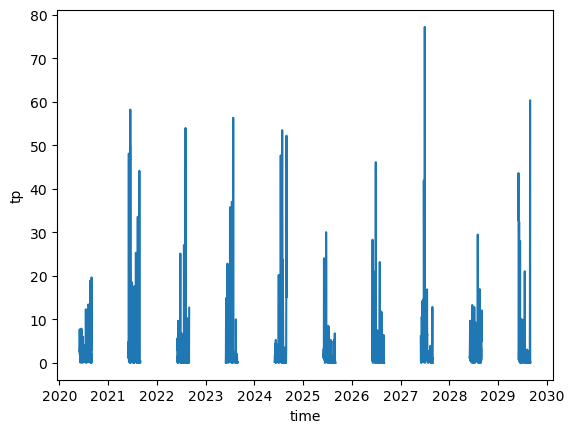

In [23]:
#(box_mod*60*60).plot()
#(box_mod*1000).sel(time=box_mod.time.dt.year.isin([2023])).plot()
(box_mod*1000).plot()
#plt.axhline(y=(0.0255654*60*60), color='r', linestyle='-') #2023, 20 / 2028, 20

In [41]:
### max value
box_mod_max = box_mod.sel(time=box_mod.time.dt.year.isin([2023])).chunk(dict(time=-1)).idxmax(dim="time").compute()
box_mod_max

<xarray.DataArray 'time' ()>
array('2023-06-29T00:00:00.000000000', dtype='datetime64[ns]')

In [10]:
###plotting

In [11]:
def nnshow(var, nx=1000, ny=1000, ax=None, **kwargs):
    """
    Plots a variable on a Healpix.

    Args:
        var (array-like): Variable on Healpix coordinates (e.g., numpy array).
        nx (int, optional): Image resolution in the x-direction (default is 1000).
        ny (int, optional): Image resolution in the y-direction (default is 1000).
        ax (matplotlib.axes.Axes, optional): Axis to plot on. If not provided,
            the current axis will be used (default is None).
        **kwargs: Additional arguments to pass to the imshow function.
    """
    if ax is None:
        ax = plt.gca()

    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    xvals = np.linspace(xlims[0], xlims[1], nx)
    yvals = np.linspace(ylims[0], ylims[1], ny)
    xvals2, yvals2 = np.meshgrid(xvals, yvals)
    latlon = ccrs.PlateCarree().transform_points(
        ax.projection, xvals2, yvals2, np.zeros_like(xvals2)
    )
    valid = np.all(np.isfinite(latlon), axis=-1)
    points = latlon[valid].T
    pix = hp.ang2pix(
        hp.npix2nside(len(var)), theta=points[0], phi=points[1], nest=Nested, lonlat=True
    )
    res = np.full(latlon.shape[:-1], np.nan, dtype=var.dtype)
    res[valid] = var[pix]
    return ax.imshow(res, extent=xlims + ylims, origin="lower", **kwargs)

In [12]:
def worldmap(var,cbar,clabel = None, ctitle = None,**kwargs):
    """
    Plot a variable on a Robinson projection world map.

    The function creates a Robinson projection world map using the provided variable
    'var'. 
    
    Args:
        var (array-like): The variable to be plotted on the world map.
        cbar (bool): A boolean flag to indicate whether to display the colorbar. If True,
            a colorbar will be shown; otherwise, no colorbar will be displayed.
        **kwargs: Additional keyword arguments to pass to the `nnshow` function.
    """
    projection = ccrs.Robinson(central_longitude=0)
    fig, ax = plt.subplots(
        figsize=(14, 7), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_global()

    nnshow(var, ax=ax, **kwargs)
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    if ctitle== None: # Set the label for the colorbar
         ax.set_title(" ")
    else:
         ax.set_title(ctitle)     
    if cbar is not False:
        cbar = plt.colorbar(ax.get_images()[0], ax=ax, orientation='vertical', pad=0.05)
        if clabel == None: # Set the label for the colorbar
            cbar.set_label(" ")
        else:
            cbar.set_label(clabel)

In [32]:
def plot_healpix(data_healpix,
                 proj = 'mercator]',
                 extent = None,
                 interactive = False,
                 cmap=cm.Spectral_r,
                 cbar = False,
                 clabel = None,
                 ctitle = None,
                 vmin = None,vmax = None,
                 savefig = False,
                savepath = None,
                closefile=False):
    
    """
    Plots data on a Healpix grid with various customization options.

    The function takes data defined on a Healpix grid and visualizes it on a specified
    map projection. 
    Args:
        data_healpix (array-like): Data on a Healpix grid.
        proj (str, optional): The map projection to use. Supported options are 'mercator',
            'np' (North Polar Stereographic), and 'sp' (South Polar Stereographic).
            Default is 'mercator'.
        extent (list, optional): The extent of the plot specified as ([min_lon, max_lon,
            min_lat, max_lat]) in degrees. Default is None, which shows the global extent.
        interactive (bool, optional): If True, the plot is displayed interactively with
            widgets for zooming and panning. If False, a static image is displayed.
            Default is False.
        cmap (colormap, optional): The colormap to use for the plot. Default is 'Spectral_r'.
        cbar (bool, optional): If True, a colorbar is displayed. If False, no colorbar is shown.
            Default is False.
        vmin (float, optional): The lower limit for the color scale. If not provided, the
            minimum value in 'data_healpix' will be used.
        vmax (float, optional): The upper limit for the color scale. If not provided, the
            maximum value in 'data_healpix' will be used.
        savefig (bool, optional): If True, the plot is saved as an image. If False, the plot
            is not saved. Default is False.
        savepath (str, optional): The path to save the image file. Default is None, which
            saves the image in the current working directory.
    """
    if (savefig == True) and (os.path.exists(savepath)):
        return
    if vmin is None:
        vmin = np.nanmin(data_healpix)
    if vmax is None:
        vmax = np.nanmax(data_healpix)
    if interactive == False:
        %matplotlib inline

        if extent == None:
            worldmap(data_healpix, cbar,clabel=clabel,ctitle=ctitle,cmap=cmap,vmin = vmin, vmax = vmax)
        else:
            if proj == 'mercator':
                projection = ccrs.Mercator(central_longitude=0)
            elif proj == 'np':
                projection = ccrs.NorthPolarStereo(central_longitude=0)
            elif proj == 'sp':
                 projection = ccrs.SouthPolarStereo(central_longitude=0)
            fig, ax = plt.subplots(
                figsize=(14, 10), subplot_kw={"projection": projection}, constrained_layout=True
            )
            ax.set_extent(extent, ccrs.PlateCarree())
            nnshow(data_healpix, ax=ax, cmap=cmap,vmin = vmin, vmax = vmax)
            ax.add_feature(cf.COASTLINE, linewidth=0.8)
            
            if ctitle== None: # Set the label for the colorbar
                    ax.set_title(" ")
            else:
                    ax.set_title(ctitle)  
            
            # Add a colorbar to the plot
            if cbar is not False:
                cbar = plt.colorbar(ax.get_images()[0], ax=ax, orientation='vertical', pad=0.05)
                if clabel== None: # Set the label for the colorbar
                    cbar.set_label(" ")
                else:
                    cbar.set_label(clabel)  
    else:
        %matplotlib widget
        hp.mollzoom(data_healpix,
                    flip="geo",
                    cmap =cmap,
                    min = vmin, max = vmax,
                    title=clabel,nest=Nested)
    if savefig == True:
        plt.savefig(savepath,dpi = 500, format = 'jpg')
    plt.show()
    if closefile == True:
        plt.close()

In [14]:
# Are we using Nested Healpix or Ring? 
Nested=True

In [15]:
ds = cat.IFS['IFS_9-FESOM_5-production']['3D_hourly_healpix512_2040'].to_dask()

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'rasterio' loading failed:
No module named 'affine'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


In [16]:
ds

<xarray.Dataset>
Dimensions:  (time: 43848, level: 25, value: 3145728)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(3145728,), meta=np.ndarray>
  * level    (level) int64 1 5 10 20 30 50 70 ... 850 875 900 925 950 975 1000
    lon      (value) float64 dask.array<chunksize=(3145728,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2040-01-01 ... 2044-12-31T23:00:00
Dimensions without coordinates: value
Data variables: (12/13)
    cc       (time, level, value) float64 dask.array<chunksize=(1, 1, 3145728), meta=np.ndarray>
    ciwc     (time, level, value) float64 dask.array<chunksize=(1, 1, 3145728), meta=np.ndarray>
    clwc     (time, level, value) float64 dask.array<chunksize=(1, 1, 3145728), meta=np.ndarray>
    crwc     (time, level, value) float64 dask.array<chunksize=(1, 1, 3145728), meta=np.ndarray>
    cswc     (time, level, value) float64 dask.array<chunksize=(1, 1, 3145728), meta=np.ndarray>
    pv       (time, level, value) float64 dask.array<chunksize=(1, 1, 3145728), meta=np.ndarray>
    ...       ...
    r        (time, level, value) float64 dask.array<chunksize=(1, 1, 3145728), meta=np.ndarray>
    t        (time, level, value) float64 dask.array<chunksize=(1, 1, 3145728), meta=np.ndarray>
    u        (time, level, value) float64 dask.array<chunksize=(1, 1, 3145728), meta=np.ndarray>
    v        (time, level, value) float64 dask.array<chunksize=(1, 1, 3145728), meta=np.ndarray>
    w        (time, level, value) float64 dask.array<chunksize=(1, 1, 3145728), meta=np.ndarray>
    z        (time, level, value) float64 dask.array<chunksize=(1, 1, 3145728), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          1003
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

In [18]:
### 2023-06-29T00:00:00.000000000',
#tp_2023_06 = ds['tp'].sel(time='2023-06-29T00')
pv_2044_01 = ds['pv'].sel(time='2044-01-16T12',level=500)
#data=model_run(zoom=2, time="P1D").to_dask().pr.sel(time="2020-07-10")

In [23]:
#(pv_2044_01*10000).plot()

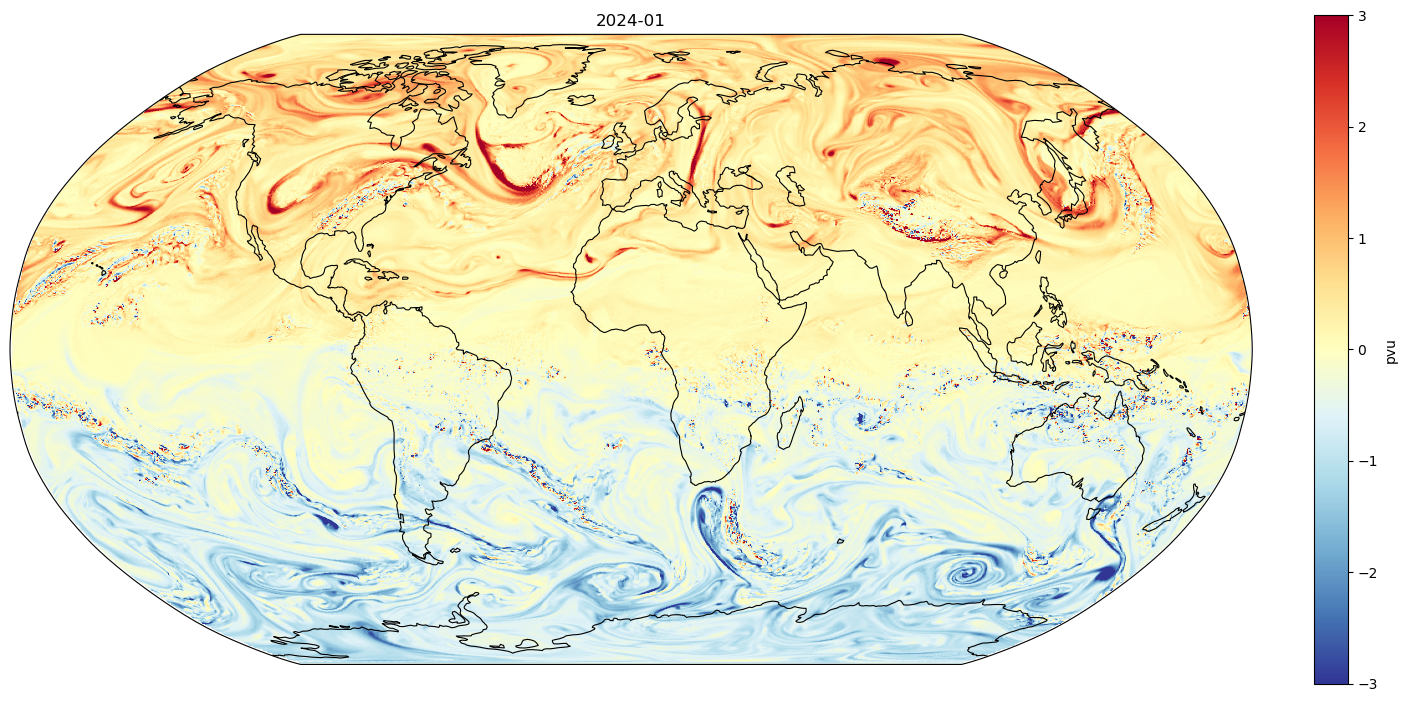

In [33]:
#plot_healpix(tp_2023_06, cbar=True,cmap='coolwarm')
plot_healpix(pv_2044_01*1000000, proj = 'np',cbar=True, clabel='pvu' , ctitle='2024-01', cmap='RdYlBu_r', savefig=False, savepath='./plots/ci_2020-24.png', vmin=-3, vmax=3)

In [68]:
msl_2023_06 = ds['msl'].sel(time='2023-06-29T00')

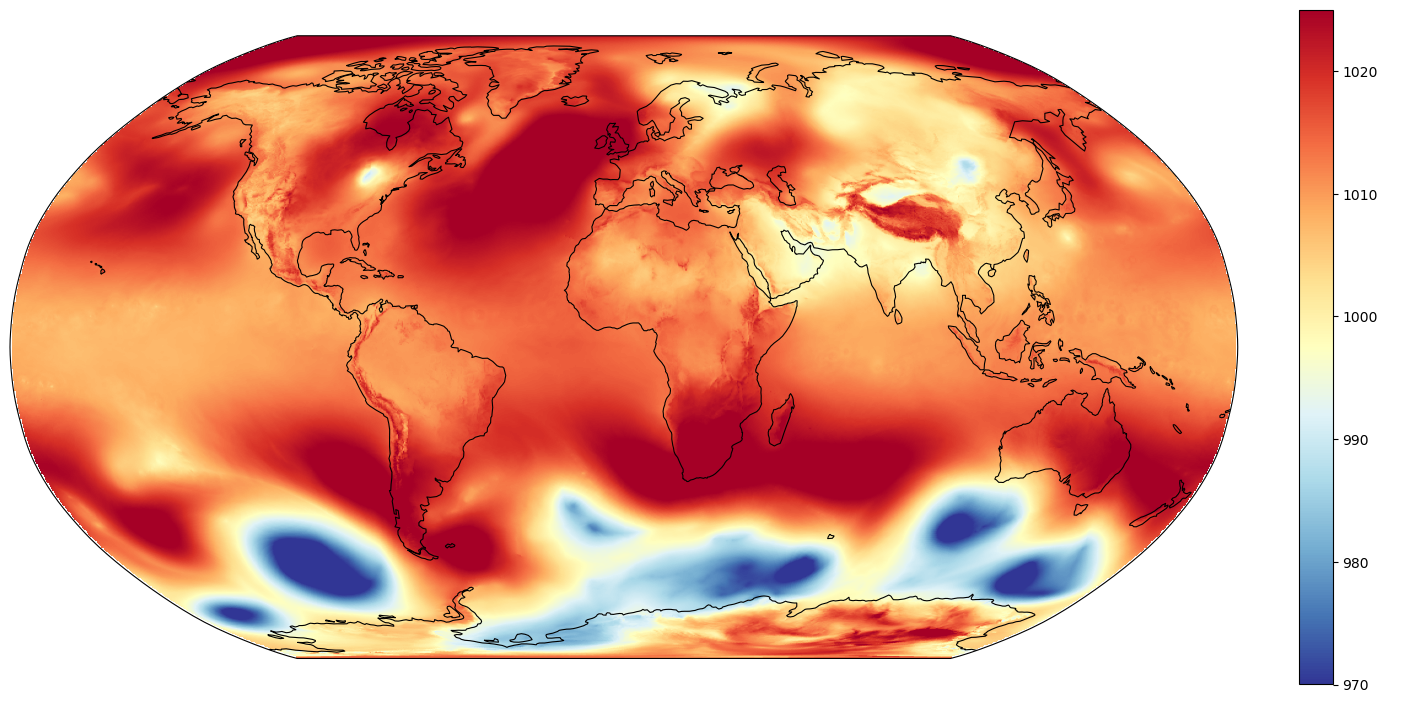

In [71]:
plot_healpix(msl_2023_06*0.01, cbar=True, cmap='RdYlBu_r', savefig=False, savepath='./plots/ci_2020-24.png', vmin=970, vmax=1025)

In [11]:
### extract 3D data
#!pip install xesmf

In [12]:
### dealing with cdo problem
#!module use /work/k20200/k202134/hsm-tools/outtake/module; module rm python3; module load python3/hamburg-hackathon; install_kernel --cdo /sw/spack-levante/cdo-2.3.0-mck3wy/bin/cdo --kernel_name python-hh-hackathon-cdo

In [13]:
### extract 3D data
import cdo
cdo = cdo.Cdo(tempdir='/scratch/b/b382006/tmp/cdo-py') # change the tempdir to your scratch

In [15]:
#import xesmf as xe

In [16]:
def convert_to_xarray(ds,var,grid='0.25'):
    # select a variable, reshape lat lon and convert to XArray DataArray
    # needs to specify an existing varname e.g. '2t'
    # assumes that ds has the shape time | value
    
    # arrange value coordinate into lat/lon
#    sample = np.reshape(ds[var].values, newshape=(len(ds.time),len(np.unique(ds.lat)),len(np.unique(ds.lon))))
    sample = np.reshape(ds[var].sel(level=500.0).values, newshape=(len(ds.time),len(np.unique(ds.lat)),len(np.unique(ds.lon))))
    
    # create DataArray with proper name, dimensions, and coordinates
    da = xr.DataArray(
        data=sample,
        name=var,
        dims=["time", "lat", "lon"],
        coords=dict(
            time=ds.time.data,
            lon=(["lon"], np.unique(ds.lon)),
            # lat=(["lat"], np.unique(ds.lat)),
            lat=(["lat"], np.unique(ds.lat)[::-1]), # use this because otherwise lats are flipped; only comment for testing
        ),
        attrs=dict(
#             variable=var,
            ds[var].attrs,            
        ),
    ) 
    
###=== attach griddes so that cdo interprets it as a regular lonlat grid:
    if grid=='025':
        my_griddes = '/work/bm1235/ifs-grids/multio_grids_cdoPython/025_griddes'
    elif grid=='1':
        my_griddes = '/work/bm1235/ifs-grids/multio_grids_cdoPython/1_griddes'
        print('here')
    else:
        raise Exception("Unsupported grid. Maybe new grid introduced in multIO?")
        
    da = cdo.setgrid(my_griddes, input=da.to_dataset(), returnXDataset=True)[var]
    
    return da

In [17]:
### Extract 3d variables daily or 6 hourly
#ds = cat.IFS['IFS_9-FESOM_5-production']['3D_hourly_healpix512'].to_dask().pipe(attach_coords) # load H512, hourly
data = cat.IFS['IFS_9-FESOM_5-production']['3D_monthly_0.25deg'].to_dask() #.pipe(attach_coords)
#data = cat.IFS['IFS_4.4-FESOM_5-cycle3']['3D_1h6h_1deg'].to_dask().resample(time='1D').mean()
data

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'rasterio' loading failed:
No module named 'affine'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


<xarray.Dataset>
Dimensions:  (time: 300, level: 25, value: 1038240)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(1038240,), meta=np.ndarray>
  * level    (level) int64 1 5 10 20 30 50 70 ... 850 875 900 925 950 975 1000
    lon      (value) float64 dask.array<chunksize=(1038240,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-02-01 2020-03-01 ... 2045-01-01
Dimensions without coordinates: value
Data variables: (12/13)
    cc       (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
    ciwc     (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
    clwc     (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
    crwc     (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
    cswc     (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
    pv       (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
    ...       ...
    r        (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
    t        (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
    u        (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
    v        (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
    w        (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
    z        (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          1003
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

In [18]:
decade=data.sel(time=slice('2020-02-01', '2029-01-01'))
decade

<xarray.Dataset>
Dimensions:  (time: 108, level: 25, value: 1038240)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(1038240,), meta=np.ndarray>
  * level    (level) int64 1 5 10 20 30 50 70 ... 850 875 900 925 950 975 1000
    lon      (value) float64 dask.array<chunksize=(1038240,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-02-01 2020-03-01 ... 2029-01-01
Dimensions without coordinates: value
Data variables: (12/13)
    cc       (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
    ciwc     (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
    clwc     (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
    crwc     (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
    cswc     (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
    pv       (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
    ...       ...
    r        (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
    t        (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
    u        (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
    v        (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
    w        (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
    z        (time, level, value) float64 dask.array<chunksize=(1, 1, 1038240), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          1003
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

In [20]:
#z500 = data.z.sel(level=500.0)
ifs_xr = convert_to_xarray(data,var='z',grid='1')   # z500
#ifs_xr

here


In [21]:
#ifs_xr

In [22]:
minx = ifs_xr.lon.min().item()
maxx = ifs_xr.lon.max().item()
miny = ifs_xr.lat.min().item()
maxy = ifs_xr.lat.max().item()
print(minx, maxx, miny, maxy)
### set up new lat/lon grid
new_grid_x = np.arange(
    np.ceil(minx),
    (np.floor(maxx) + 1),1)

new_grid_y = np.arange(
    np.ceil(miny),(np.floor(maxy) + 1),1)
print(new_grid_x,new_grid_y)
### interpolate using nearest neighbor (can use linear, etc. if desired)
coarse = ifs_xr.interp(lon=new_grid_x, lat=new_grid_y, method="nearest")  
#coarse


-180.0 179.75 -90.0 90.0
[-180. -179. -178. -177. -176. -175. -174. -173. -172. -171. -170. -169.
 -168. -167. -166. -165. -164. -163. -162. -161. -160. -159. -158. -157.
 -156. -155. -154. -153. -152. -151. -150. -149. -148. -147. -146. -145.
 -144. -143. -142. -141. -140. -139. -138. -137. -136. -135. -134. -133.
 -132. -131. -130. -129. -128. -127. -126. -125. -124. -123. -122. -121.
 -120. -119. -118. -117. -116. -115. -114. -113. -112. -111. -110. -109.
 -108. -107. -106. -105. -104. -103. -102. -101. -100.  -99.  -98.  -97.
  -96.  -95.  -94.  -93.  -92.  -91.  -90.  -89.  -88.  -87.  -86.  -85.
  -84.  -83.  -82.  -81.  -80.  -79.  -78.  -77.  -76.  -75.  -74.  -73.
  -72.  -71.  -70.  -69.  -68.  -67.  -66.  -65.  -64.  -63.  -62.  -61.
  -60.  -59.  -58.  -57.  -56.  -55.  -54.  -53.  -52.  -51.  -50.  -49.
  -48.  -47.  -46.  -45.  -44.  -43.  -42.  -41.  -40.  -39.  -38.  -37.
  -36.  -35.  -34.  -33.  -32.  -31.  -30.  -29.  -28.  -27.  -26.  -25.
  -24.  -23.  -22.  -21.  

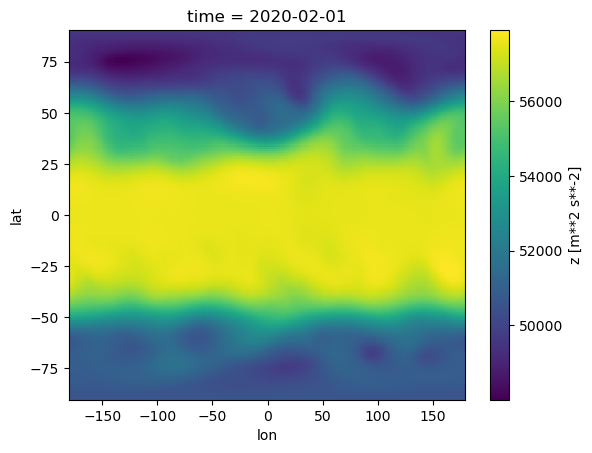

In [24]:
coarse.isel(time=0).plot()
#ifs_xr.isel(time=0).plot()

In [26]:
mm=[1,2,12]
period_z = coarse.sel(time=coarse.time.dt.month.isin(mm))

#period_z = data.z.sel(plev=50000.0, time=data_z.time.dt.month.isin([1, 2, 12]))
period_mean_z=period_z.mean(dim='time')

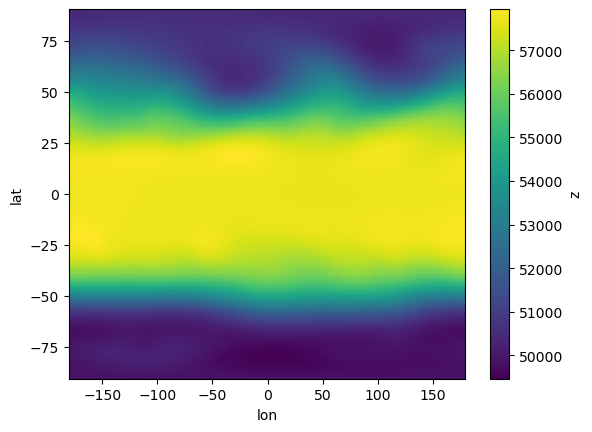

In [28]:
period_mean_z.plot()

In [11]:
########
### from healpix

In [11]:
data = cat.IFS['IFS_9-FESOM_5-production']['3D_hourly_healpix512_2045'].to_dask()
###data = cat.IFS['IFS_9-FESOM_5-production']['3D_hourly_healpix512'].to_dask()
#data = cat.IFS['IFS_9-FESOM_5-production']['3D_hourly_healpix512_2020'].to_dask().pipe(attach_coords)

/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'rasterio' loading failed:
No module named 'affine'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/fastdata/bm1235/python_environments/hamburg-hackathon/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


In [12]:
data

<xarray.Dataset>
Dimensions:  (time: 43824, level: 25, value: 3145728)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(3145728,), meta=np.ndarray>
  * level    (level) int64 1 5 10 20 30 50 70 ... 850 875 900 925 950 975 1000
    lon      (value) float64 dask.array<chunksize=(3145728,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2045-01-01 ... 2049-12-31T23:00:00
Dimensions without coordinates: value
Data variables: (12/13)
    cc       (time, level, value) float64 dask.array<chunksize=(1, 1, 3145728), meta=np.ndarray>
    ciwc     (time, level, value) float64 dask.array<chunksize=(1, 1, 3145728), meta=np.ndarray>
    clwc     (time, level, value) float64 dask.array<chunksize=(1, 1, 3145728), meta=np.ndarray>
    crwc     (time, level, value) float64 dask.array<chunksize=(1, 1, 3145728), meta=np.ndarray>
    cswc     (time, level, value) float64 dask.array<chunksize=(1, 1, 3145728), meta=np.ndarray>
    pv       (time, level, value) float64 dask.array<chunksize=(1, 1, 3145728), meta=np.ndarray>
    ...       ...
    r        (time, level, value) float64 dask.array<chunksize=(1, 1, 3145728), meta=np.ndarray>
    t        (time, level, value) float64 dask.array<chunksize=(1, 1, 3145728), meta=np.ndarray>
    u        (time, level, value) float64 dask.array<chunksize=(1, 1, 3145728), meta=np.ndarray>
    v        (time, level, value) float64 dask.array<chunksize=(1, 1, 3145728), meta=np.ndarray>
    w        (time, level, value) float64 dask.array<chunksize=(1, 1, 3145728), meta=np.ndarray>
    z        (time, level, value) float64 dask.array<chunksize=(1, 1, 3145728), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          1003
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

In [13]:
data_example = data['z'][-1,:].sel(level=500)

In [14]:
data_example #.sel(level=500)

<xarray.DataArray 'z' (value: 3145728)>
dask.array<getitem, shape=(3145728,), dtype=float64, chunksize=(3145728,), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(3145728,), meta=np.ndarray>
    level    int64 500
    lon      (value) float64 dask.array<chunksize=(3145728,), meta=np.ndarray>
    time     datetime64[ns] 2049-12-31T23:00:00
Dimensions without coordinates: value
Attributes: (12/15)
    paramId:                    129
    dataType:                   fc
    numberOfPoints:             3145728
    typeOfLevel:                isobaricInhPa
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    name:                       Geopotential
    cfName:                     geopotential
    cfVarName:                  z
    missingValue:               9999
    NV:                         0
    gridDefinitionDescription:  150

In [15]:
# Find the HEALPix pixels that are closest to the 1x1 degree grid points.
#lon = np.arange(0, 360, 1)
#lat = np.arange(90, -91, -1)
#pix = xr.DataArray(
#    hp.ang2pix(data.crs.healpix_nside, *np.meshgrid(lon, lat), nest=True, lonlat=True),
#    coords=(("lat", lat), ("lon", lon)),
#)

lon = np.linspace(-179, 180, 360)
lat = np.linspace(-90, 90, 181)
lon2, lat2 = np.meshgrid(lon, lat)

In [16]:
pix = hp.ang2pix(
        hp.npix2nside(len(data_example)), theta=lon2, phi=lat2, nest=True, lonlat=True
    )

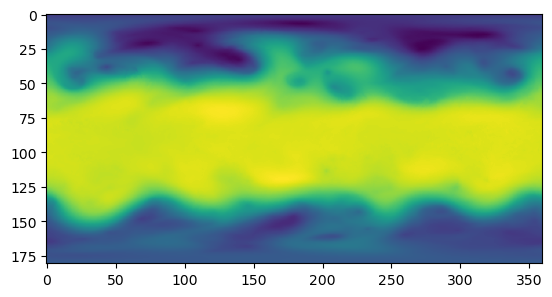

In [17]:
plt.imshow(np.flipud(data_example.values[pix]))

In [18]:
#inst='2020-01-20T06'
#tmp=data['z'].sel(level=500,time=inst)
#data.sel(time=inst)

#np.reshape(data_example.values[pix],newshape=(len(lat),len(lon)))
#tmp
#period=data['time'].sel(time='2020-01')
#period[::6]

In [19]:
## Horizontal interpolation var_500, Save 3D variable
#var='z'
##sample = np.reshape(tmp.isel(value=pix).values,newshape=(len(tmp.time),len(lat),len(lon)))
#sample = np.reshape(tmp.values[pix],newshape=(1,len(lat),len(lon)))
#
#        # create DataArray with proper name, dimensions, and coordinates
#da = xr.DataArray(
#            data=sample,
#            name=var,
#            dims=["time","lat", "lon"],
#            coords=dict(
#                lon=lon,
#                lat=lat,
#                time=data['time'].sel(time=inst)
#            ),
#            attrs=dict(
#            data[var].attrs,
#            ),
#        )

In [20]:
#da.isel(time=0).plot()

In [21]:
### make a loop
pix = hp.ang2pix(
        hp.npix2nside(len(data_example)), theta=lon2, phi=lat2, nest=True, lonlat=True
    )

In [23]:
var='z'
prs=500
version='IFS_9-FESOM_5-production'
dir_res="/scratch/b/b382006/nextgems/prefinal/"+version+"/"+var+"/6H/"
if not os.path.exists(dir_res):
    os.makedirs(dir_res)

print("Saving in :", dir_res)
yy0=data["time.year"][0].values
#yy0=2041
yyn=data["time.year"][-1].values
#yyn=2040
print(yy0,yyn)

Saving in : /scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production/z/6H/
2045 2049


In [ ]:
for yyyy in range(yy0,yyn+1):
    print(yyyy)    
    for mm in range(1,13):
        yyyymm=str(yyyy)+'-'+str(mm).zfill(2)
        print(yyyymm)
    
        period=data['time'].sel(time=yyyymm)

        lev_list = []
        for inst in  period[::6]:
#        print(inst.values)
            tmp=data[var].sel(level=500,time=inst.values)
    
            sample = np.reshape(tmp.values[pix],newshape=(1,len(lat),len(lon)))
    
        # create DataArray with proper name, dimensions, and coordinates
            da = xr.DataArray(
            data=sample,
            name=var,
            dims=["time","lat", "lon"],
            coords=dict(
                lon=lon,
                lat=lat,
                time=np.atleast_1d(data['time'].sel(time=inst.values))
            ),
            attrs=dict(
            data[var].attrs,
            ),
            )

            lev_list.append(da)

        geo_xr = xr.combine_by_coords(lev_list)
        geo_xr.to_netcdf(dir_res+var+str(prs)+'_'+version+'_'+yyyymm+'.nc')

2045
2045-01
2045-02
2045-03
2045-04


In [ ]:
#geo_xr['z'].isel(time=-1).plot()
